In [62]:
import pandas as pd
import numpy as np
import time
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [63]:
TRAIN_FILE_PATH = './archive/train.csv'

data = pd.read_csv(TRAIN_FILE_PATH)

In [64]:
#Id en Name zijn niet relevant voor het model
data = data.drop(['PassengerId', 'Name'], axis=1)

In [65]:
data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [78]:
#print gemiddelde age van wel en niet getransporteerde mensen
print(data.groupby('Transported')['Age'].mean())
#nu voor vip
print(data.groupby('Transported')['VIP'].mean())
#nu per destination hoeveel wel en hoeveel niet getransporteerd zijn in percentages
print(data.groupby('Destination')['Transported'].mean())

Transported
False    29.922858
True     27.748834
Name: Age, dtype: float64
Transported
False    0.029175
True     0.017782
Name: VIP, dtype: object
Destination
55 Cancri e      0.610000
PSO J318.5-22    0.503769
TRAPPIST-1e      0.471175
Name: Transported, dtype: float64


In [66]:
data = data.sample(frac=1)
train_data = data[:int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]

train_x = train_data.drop(['Transported'], axis=1)
train_y = train_data['Transported']

test_x = test_data.drop(['Transported'], axis=1)
test_y = test_data['Transported']

#encode the data using sklearn.preprocessing.LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_x = train_x.apply(le.fit_transform)
test_x = test_x.apply(le.fit_transform)

In [67]:
param_grid = {'C': [0.1, 1, 10, 100],
                'degree': [0, 3, 6],
                'kernel':['poly', 'rbf', 'sigmoid']}

iterations = 5

grid = GridSearchCV(SVC(), param_grid, refit=True, cv=iterations, verbose=3, n_jobs=-1)

start = time.time()

grid.fit(train_x, train_y)

end = time.time()

print(f"Training time: {end - start}s")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training time: 188.62701606750488s


In [68]:
best_score = grid.best_score_
best_params = grid.best_params_

with open('result.txt', 'a') as f:
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Best score: {best_score}\n")
    f.write(f"Best params: {best_params}\n")
    f.write(f"Training time: {end - start}s\n\n")

In [69]:
gs_results = pd.DataFrame(grid.cv_results_)
gs_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
gs_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
31,2.610461,0.166644,0.576548,0.014741,100,3,rbf,"{'C': 100, 'degree': 3, 'kernel': 'rbf'}",0.779295,0.774263,0.759166,0.792955,0.781295,0.777395,0.010982,1
34,2.598985,0.121226,0.567128,0.014088,100,6,rbf,"{'C': 100, 'degree': 6, 'kernel': 'rbf'}",0.779295,0.774263,0.759166,0.792955,0.781295,0.777395,0.010982,1
28,2.791921,0.161284,0.580331,0.011943,100,0,rbf,"{'C': 100, 'degree': 0, 'kernel': 'rbf'}",0.779295,0.774263,0.759166,0.792955,0.781295,0.777395,0.010982,1
25,1.907874,0.223953,0.604534,0.020795,10,6,rbf,"{'C': 10, 'degree': 6, 'kernel': 'rbf'}",0.776420,0.763480,0.756290,0.784328,0.777698,0.771643,0.010225,4
22,1.991673,0.148579,0.609817,0.020392,10,3,rbf,"{'C': 10, 'degree': 3, 'kernel': 'rbf'}",0.776420,0.763480,0.756290,0.784328,0.777698,0.771643,0.010225,4


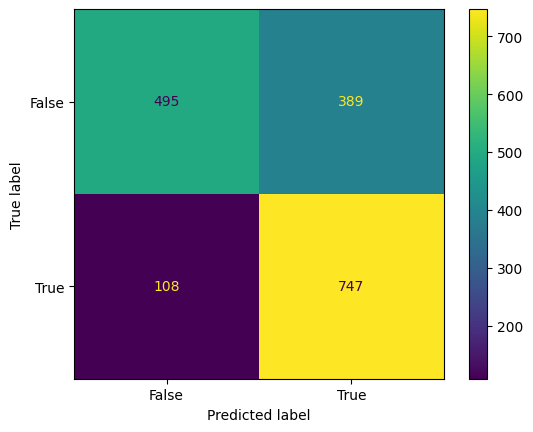

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, test_x, test_y)


#1660 van de 2200